Objective
The objective of this exercise is to identify which ZIP codes are overpriced (in terms of rent) relative to fundamentals and which are underpriced (in terms of rent) as of 2022 relative to fundamentals.

Note: overprice/underprice means the gap between actual price and what is justified by fundamentals and not necessarily the highest/lowest set of prices.

Data available
Zillow Observed Rent Index (ZORI) - 'RegionID' is ZIP (ZIP is equivalent to postal code in Canada)
Zillow Home Value Index (ZHVI) - 'RegionID' is ZIP
Economic and demographic data for 2022 from XXX Group
Successful completion of this exercise would do the following:
Create a list of the top 10 most overpriced ZIP codes as of 2022 -> Explain what contributes most to the ZIP code being most overpriced.
Create a list of the top 10 most underpriced ZIP codes as of 2022 -> Explain what contributes most to the ZIP code being most underpriced.
Use data science or statistical best practices to build confidence in the validity of (1) and (2)
Clearly document, organize and explain the building blocks to generate (1) and (2)

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [50]:
def load_and_inspect_data():
    try:
        zori_df = pd.read_csv('Zip_zori_sm_sa_month.csv')
        zhvi_df = pd.read_csv('Zip_zhvi_sm_sa_month.csv')
        econ_df = pd.read_csv('df_eco_demo_2022 (1).csv')
        return zori_df, zhvi_df, econ_df
    except Exception as e:
        print(f'Error loading data: {e}')
        return None, None, None

# Load and inspect
zori_df, zhvi_df, econ_df = load_and_inspect_data()

print('Zori DF Head:')
print(zori_df.head())

print('Zhvi DF Head:')
print(zhvi_df.head())

print('Econ DF Head:')
print(econ_df.head())

Zori DF Head:
   RegionID  SizeRank  RegionName  ... 31/10/2023 30/11/2023 31/12/2023
0     91982         1       77494  ...       %.2f       %.2f       %.2f
1     91940         3       77449  ...       %.2f       %.2f       %.2f
2     91733         5       77084  ...       %.2f       %.2f       %.2f
3     93144         6       79936  ...       %.2f       %.2f       %.2f
4     62093         7       11385  ...       %.2f       %.2f       %.2f

[5 rows x 117 columns]
Zhvi DF Head:
   RegionID  SizeRank  RegionName  ... 31/10/2023 30/11/2023 31/12/2023
0     91982         1       77494  ...       %.2f       %.2f       %.2f
1     61148         2        8701  ...       %.2f       %.2f       %.2f
2     91940         3       77449  ...       %.2f       %.2f       %.2f
3     62080         4       11368  ...       %.2f       %.2f       %.2f
4     91733         5       77084  ...       %.2f       %.2f       %.2f

[5 rows x 297 columns]
Econ DF Head:
    ZIP  ...  Unemployment rate, 2022
0  1001 

In [51]:
def merge_and_prepare_datasets(zori_df, zhvi_df, econ_df):
    # Get December 2022 values
    target_date = '31/12/2022'
    
    # Create simplified dataframes with just RegionID and December 2022 values
    zori_simple = pd.DataFrame({
        'RegionID': zori_df['RegionID'],
        'RegionName': zori_df['RegionName'],
        'StateName': zori_df['StateName'],
        'ZORI': zori_df[target_date]
    })
    
    zhvi_simple = pd.DataFrame({
        'RegionID': zhvi_df['RegionID'],
        'ZHVI': zhvi_df[target_date]
    })
    
    # Convert ZIP to RegionID in econ_df
    econ_df['RegionID'] = econ_df['ZIP']
    
    # Merge datasets
    merged_df = zori_simple.merge(zhvi_simple, on='RegionID', how='inner')
    merged_df = merged_df.merge(econ_df, on='RegionID', how='inner')
    
    # Drop rows with NaN values
    merged_df = merged_df.dropna()
    
    print(f"\nShape after merging and dropping NaN: {merged_df.shape}")
    print(f"\nSample of merged data:")
    print(merged_df.head())
    
    return merged_df

def create_features(df):
    # Create feature matrix X with all predictors
    feature_columns = [
        'Blue Collar Employment Share',
        'Tech Employment Share',
        'Hachman Index (employment diversity), 2021',
        'Median household net worth, 2022',
        'Median renter income, 2022',
        'National risk index ',  # Note the space at the end
        'Net migration rate, 2022',
        'Pct. of all households, Renter, 2022',
        'Pct. of all population, BA or higher, 2022',
        'Pct. of all population, age 25 to 34, 2022',
        'Renter affordability, 2022',
        'Unemployment rate, 2022',
        'ZHVI'  # Adding home values as a predictor
    ]
    
    # Target is actual ZORI (rent prices)
    y = df['ZORI']
    
    # Drop any rows with NaN values
    df_clean = df.dropna(subset=feature_columns + ['ZORI'])
    
    print("\nShape after cleaning:")
    print(f"Original shape: {df.shape}")
    print(f"Clean shape: {df_clean.shape}")
    
    # Store location information
    location_info = df_clean[['RegionID', 'RegionName', 'StateName']]
    
    return df_clean[feature_columns], df_clean['ZORI'], location_info

In [52]:
def analyze_feature_significance(X, y, feature_names):
    # Reset indices to ensure alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # Add constant for statsmodels
    X_with_const = sm.add_constant(X)

    # Fit OLS model
    model = sm.OLS(y, X_with_const)
    results = model.fit()

    # Get coefficients and p-values
    coef = results.params[1:]  # Skip constant
    p_values = results.pvalues[1:]  # Skip constant

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coef,
        'P_Value': p_values,
        'Significant': p_values < 0.05,
        'Std Error': results.bse[1:],
        'T-Statistic': results.tvalues[1:],
        'CI_Lower': results.conf_int().iloc[1:, 0],
        'CI_Upper': results.conf_int().iloc[1:, 1]
    })

    # Add absolute coefficient for sorting
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    return feature_importance, results

In [55]:
def analyze_residuals(model, X, y, location_info, scaler):
    # Get predictions
    y_pred = model.predict(X)
    
    # Calculate residuals
    residuals = y - y_pred
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'RegionID': location_info['RegionID'],
        'RegionName': location_info['RegionName'],
        'StateName': location_info['StateName'],
        'Actual_Rent': y,
        'Predicted_Rent': y_pred,
        'Residual': residuals,
        'Percent_Difference': (residuals / y_pred) * 100
    })
    
    # Sort by residuals to find most over/underpriced
    overpriced = results_df.nlargest(10, 'Residual')
    underpriced = results_df.nsmallest(10, 'Residual')
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': model.coef_
    })
    feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)
    
    return overpriced, underpriced, feature_importance, results_df

def train_and_evaluate_model(X, y, location_info, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test, loc_train, loc_test = train_test_split(
        X, y, location_info, test_size=test_size, random_state=random_state
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert to DataFrame to keep feature names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

    # Reset indices to ensure alignment
    X_train_scaled = X_train_scaled.reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True)
    X_test_scaled = X_test_scaled.reset_index(drop=True)
    y_test = pd.Series(y_test).reset_index(drop=True)

    # Analyze feature significance using the training data
    feature_importance, model_results = analyze_feature_significance(X_train_scaled, y_train, X.columns)

    # Print detailed statistical results
    print("\nDetailed Statistical Results:")
    print(model_results.summary())

    print("\nFeature Significance Analysis:")
    print("Features sorted by importance (absolute coefficient value):")

    # Reset the float format to show full values
    pd.set_option('display.float_format', None)

    # Create detailed feature analysis table
    feature_analysis = feature_importance[['Feature', 'Coefficient', 'Std Error', 'T-Statistic',
                                         'P_Value', 'Significant', 'CI_Lower', 'CI_Upper']]

    print("\nDetailed Feature Analysis:")
    with pd.option_context('display.max_rows', None,
                          'display.max_columns', None,
                          'display.width', None):
        print(feature_analysis)

    # Calculate predictions for residual analysis
    y_pred_test = model_results.predict(sm.add_constant(X_test_scaled))
    residuals = y_test - y_pred_test

    # Create results DataFrame
    results_df = pd.DataFrame({
        'RegionID': loc_test['RegionID'].reset_index(drop=True),
        'RegionName': loc_test['RegionName'].reset_index(drop=True),
        'StateName': loc_test['StateName'].reset_index(drop=True),
        'Actual_Rent': y_test,
        'Predicted_Rent': y_pred_test,
        'Residual': residuals,
        'Percent_Difference': (residuals / y_pred_test) * 100
    })

    # Format specific columns
    results_df['Predicted_Rent'] = results_df['Predicted_Rent'].round(2)
    results_df['Actual_Rent'] = results_df['Actual_Rent'].round(2)
    results_df['Percent_Difference'] = results_df['Percent_Difference'].round(2)

    # Find most over/underpriced
    overpriced = results_df.nlargest(10, 'Residual')
    underpriced = results_df.nsmallest(10, 'Residual')

    print("\nTop 10 Most Overpriced ZIP Codes:")
    print(overpriced[['RegionID', 'RegionName', 'StateName', 'Actual_Rent',
                      'Predicted_Rent', 'Percent_Difference']].to_string())

    print("\nTop 10 Most Underpriced ZIP Codes:")
    print(underpriced[['RegionID', 'RegionName', 'StateName', 'Actual_Rent',
                       'Predicted_Rent', 'Percent_Difference']].to_string())

    # Visualize residuals
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_pred_test, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Rent')
    plt.ylabel('Residual')
    plt.title('Residuals vs Predicted Values')

    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30)
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.title('Distribution of Residuals')

    plt.tight_layout()
    plt.show()

    # Feature importance plot with significance
    plt.figure(figsize=(12, 6))
    colors = ['green' if sig else 'red' for sig in feature_importance['Significant']]
    plt.bar(range(len(feature_importance)), feature_importance['Abs_Coefficient'], color=colors)
    plt.xticks(range(len(feature_importance)), feature_importance['Feature'], rotation=45, ha='right')
    plt.title('Feature Importance (Absolute Coefficient Values)\nGreen: Significant (p < 0.05), Red: Not Significant')
    plt.tight_layout()
    plt.show()

    return model_results, feature_importance, results_df

Available DataFrames and their shapes:
zori_df: (6241, 117)
zhvi_df: (26354, 297)
econ_df: (32909, 14)

Merging datasets...

Shape after merging and dropping NaN: (1468, 18)

Sample of merged data:
   RegionID  RegionName  ... Renter affordability, 2022  Unemployment rate, 2022
0     91733       77084  ...                   0.221635                 0.069020
1     62093       11385  ...                   0.125863                 0.015466
2     62019       11208  ...                   0.105387                 0.057028
3     84630       60629  ...                   0.133093                 0.020816
5     62085       11373  ...                   0.162698                 0.060678

[5 rows x 18 columns]

Creating features...

Shape after cleaning:
Original shape: (1468, 18)
Clean shape: (1468, 18)

Training model and analyzing results...

Detailed Statistical Results:
                            OLS Regression Results                            
Dep. Variable:                   ZORI   R-squa

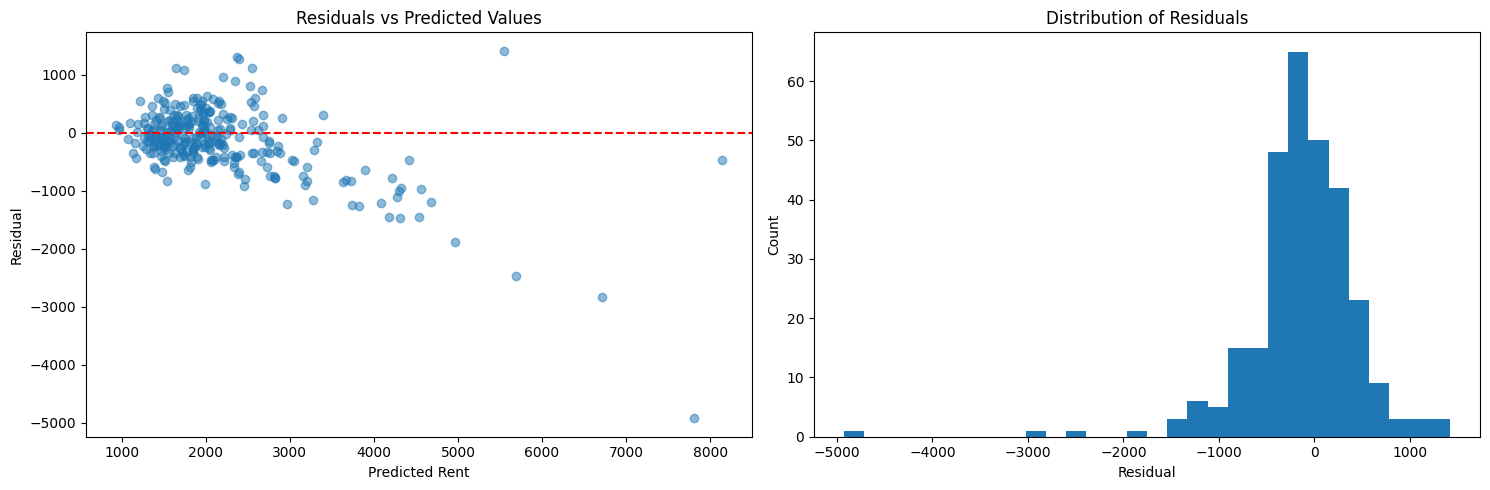

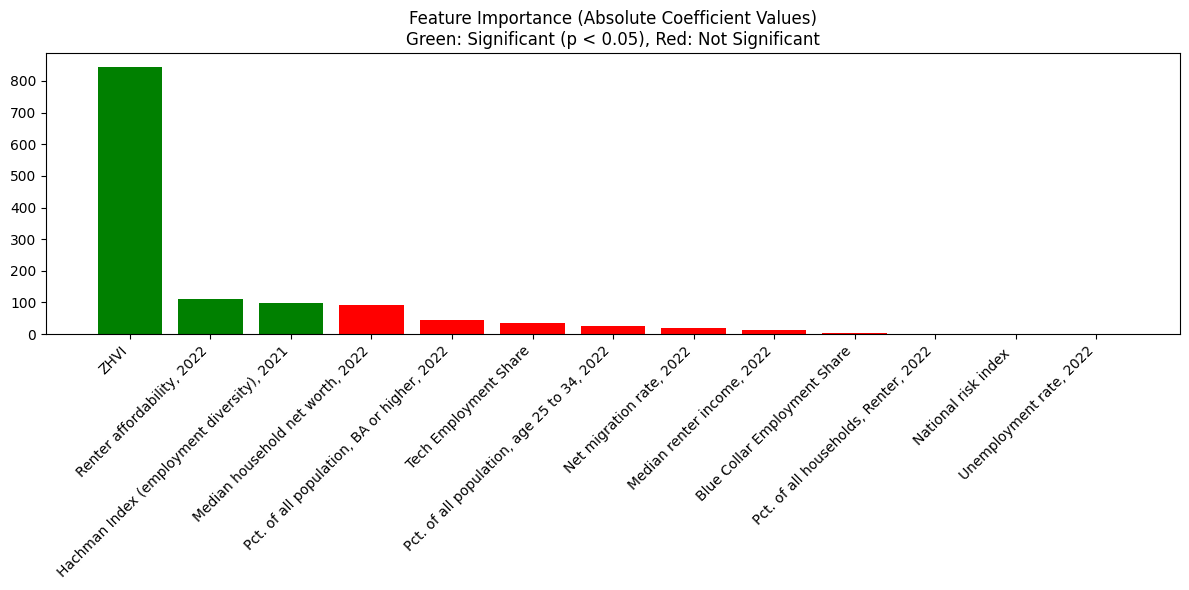

In [56]:
# Check if we have the DataFrames loaded
print("Available DataFrames and their shapes:")
for var in ['zori_df', 'zhvi_df', 'econ_df']:
    if var in globals():
        print(f"{var}: {globals()[var].shape}")
    else:
        print(f"{var} not found")

# If we have all DataFrames, proceed with merging and analysis
if all(df in globals() for df in ['zori_df', 'zhvi_df', 'econ_df']):
    # Merge datasets
    print("\nMerging datasets...")
    merged_df = merge_and_prepare_datasets(zori_df, zhvi_df, econ_df)
    
    # Create features and target
    print("\nCreating features...")
    X, y, location_info = create_features(merged_df)
    
    # Train model and analyze results
    print("\nTraining model and analyzing results...")
    model_results, feature_importance, results_df = train_and_evaluate_model(X, y, location_info)
else:
    print("\nPlease load the data first using:")
    print("zori_df = pd.read_csv('your_zori_file.csv')")
    print("zhvi_df = pd.read_csv('your_zhvi_file.csv')")
    print("econ_df = pd.read_csv('your_economic_file.csv')")